In [1]:
import warnings
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from fibrosisanalysis.parsers.stats_loader import StatsLoader
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder
from fibrosisanalysis.analysis import (
    ObjectsPropertiesBuilder,
    SegmentsPropertiesBuilder
)


def collect_slice_data(path, heart, slice_name, n_radial, n_angular, node_step):
    property_columns = ['area',
                        'major_axis_length',
                        'minor_axis_length',
                        'orientation',
                        'centroid-0',
                        'centroid-1']
    loc_bins = np.linspace(0, n_angular * n_radial, n_radial + 1)
    loc_labels = ['SUB-ENDO', 'MID', 'SUB-EPI']
    
    heart_slice_builder = HeartSliceBuilder()
    heart_slice_builder.build_from_file(path,
                                        heart,
                                        slice_name,
                                        n_angular,
                                        n_radial,
                                        node_step)
    heart_slice = heart_slice_builder.heart_slice

    obj_props = []

    for subdir in ['Stats', 'StatsDS', 'StatsGenerated']:
        path_slice_stats = path.joinpath(heart, subdir, slice_name)
        stats_loader = StatsLoader(path, subdir, property_columns)
        object_stats = stats_loader.load_slice_data(path_slice_stats)

        # Build objects properties
        objects_props_builder = ObjectsPropertiesBuilder()
        objects_props_builder.build_from_stats(object_stats)
        objects_props_builder.add_slice_props(heart_slice)
        objects_props = objects_props_builder.objects_props

        objects_props['location'] = pd.cut(objects_props['segment_labels'],
                                            bins=np.linspace(0,
                                                            n_angular * n_radial,
                                                            n_radial + 1),
                                            labels=['SUB-ENDO', 'MID', 'SUB-EPI'])
        objects_props['dataset'] = subdir
        objects_props['heart'] = heart
        obj_props.append(objects_props)

    return obj_props


def collect_data(path, hearts, n_radial, n_angular, node_step):
    obj_props = []

    for heart in hearts[:]:
        path_ = path.joinpath(heart, 'Stats')

        files = list(path_.glob('*{}'.format('.pkl')))
        files = sorted(
            [file.stem for file in files if not file.name.startswith('.')])

        data = Parallel(n_jobs=6)(delayed(collect_slice_data)(path,
                                                              heart,
                                                              slice_name,
                                                              n_radial,
                                                              n_angular,
                                                              node_step) for slice_name in tqdm(files[:]))
        
        obj_props += data

    return obj_props

In [2]:
from pathlib import Path
import warnings
warnings.simplefilter("ignore", UserWarning)

path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')

hearts = ['E10691_RBM20', 'E11444_LMNA', 'E10927_MYBPC3']
# hearts = ['E11444_LMNA']

n_angular = 12
n_radial = 3
node_step = 3

obj_props = collect_data(path, hearts, n_radial, n_angular, node_step)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [3]:
obj_props = [data for sublist in obj_props for data in sublist]
obj_props = pd.concat(obj_props, ignore_index=True)

In [9]:
import seaborn as sns
import numpy as np


def plot_sa(ax, data, title, palette, y, y_lim=[0.7, 4.7]):
    # print(data.head())
    sns.boxplot(data=data,
                y=y,
                x='location',
                hue='dataset',
                order=['SUB-ENDO', 'MID', 'SUB-EPI'],
                hue_order=['Histological', 'Direct Sampling', 'Uniform Generator'],
                ax=ax,
                palette=palette,
                showfliers=False,
                showmeans=True)
        
    ax.set_xlabel('')
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)

    ax.set_yticks(np.arange(np.ceil(y_lim[0]), y_lim[1]))
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.set_ylim(*y_lim)

    # ax.legend_.remove()

    ax.grid(axis='y', linestyle='-', alpha=0.5)
    ax.set_ylabel('', fontsize=10)

    ax.set_title(title, fontsize=10, loc='left')

In [5]:
df = obj_props[obj_props['heart'] == 'E11444_LMNA']
plt.figure()
sns.boxplot(data=df,
            y='axis_ratio',
            x='location',
            hue='dataset',
            order=['SUB-ENDO', 'MID', 'SUB-EPI'],
            hue_order=['Stats', 'StatsDS', 'StatsGenerated'],
            showfliers=False, showmeans=True)
plt.show()

NameError: name 'plt' is not defined

In [6]:
sources = {'Stats': 'Histological',
           'StatsDS': 'Direct Sampling',
           'StatsGenerated': 'Uniform Generator'}

obj_props['dataset'] = obj_props['dataset'].map(sources)

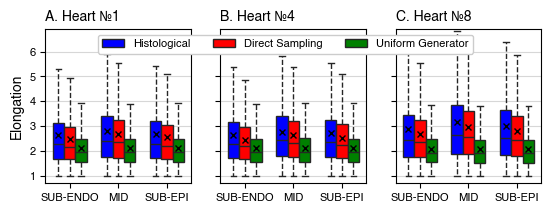

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rc('font', family='Helvetica')

titles = ['A', 'B', 'C']
heart_labels = [f'Heart №{i}' for i in [1, 4, 8]]
COLORS = {'Histological': 'blue',
          'Uniform Generator': 'green', 
          'Direct Sampling': 'red'}

fig, axs = plt.subplots(ncols=3, figsize=(6.4, 2.), sharey=True)

for i, heart in enumerate(hearts):
    ax = axs[i]
    df = obj_props[obj_props['heart'] == heart]
    sns.boxplot(data=df, y='axis_ratio', x='location', hue='dataset',
                order=['SUB-ENDO', 'MID', 'SUB-EPI'],
                hue_order=['Histological', 'Direct Sampling', 'Uniform Generator'],
                ax=ax, palette=COLORS, linewidth=1, saturation=1,
                showfliers=False, showmeans=True, meanline=False,
                whiskerprops=dict(linewidth=1, linestyle='--'),
                boxprops=dict(linewidth=1),
                capprops=dict(linewidth=1),
                medianprops=dict(linewidth=1),
                meanprops=dict(linewidth=1, marker='x', markersize=5,
                               markerfacecolor='black', markeredgecolor='black'),
                flierprops=dict(marker='o', markersize=5, 
                                markerfacecolor='black',
                                markeredgecolor='black',),
                width=0.7,
                gap=.0)


    # for violin in ax.collections[::2]:
    #     violin.set_alpha(0.5)
        
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylim(0.7, 6.9)

    # ax.set_xticklabels(heart_labels, fontsize=10)
    # plt.xticks(rotation=45)

    ax.legend_.remove()

    ax.grid(axis='y', linestyle='-', alpha=0.5)
    ax.set_ylabel('', fontsize=10)

axs[0].set_yticks(np.arange(1, 7, 1))
axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=8)

axs[0].set_title('A. Heart №1', fontsize=10, loc='left')
axs[1].set_title('B. Heart №4', fontsize=10, loc='left')
axs[2].set_title('C. Heart №8', fontsize=10, loc='left')

axs[0].set_ylabel('Elongation', fontsize=10)
fig.legend(handles=axs[0].get_legend_handles_labels()[0],
           labels=axs[0].get_legend_handles_labels()[1],
           loc='upper center', 
           bbox_to_anchor=(0.5, 0.88),
           facecolor='white',
           framealpha=1,
           ncol=3, prop={'size': 8})
# fig.legend(loc='upper center', ncol=3, prop={'size': 10})
# plt.subplots_adjust(top=0.95,
#                     bottom=0.2,
#                     left=0.1,
#                     right=0.9,
#                     hspace=0.1,
#                     wspace=0.05)
plt.show()

In [28]:
path_save = Path('/Users/arstanbek/Projects/fibrosis/FibrosisAnalysis/paperfigures/pdffig')
fig.savefig(path_save.joinpath('Figure6.pdf'),
            format='pdf',
            dpi=1000,
            bbox_inches='tight') 

In [40]:
from matplotlib import ticker
import seaborn as sns
import numpy as np


def degrees_formatter(x, pos):
    return f'{x * 180 / np.pi:.0f}°'


def plot_orientation(ax, data, palette, location, y_lim=[0, 9.5], nbins=28):
    sns.histplot(data=data,
                    x='relative_orientation',
                    hue='dataset',
                    hue_order=['Histological', 'Direct Sampling', 'Uniform Generator'],
                    bins=np.linspace(-90, 90, nbins) / 180 * np.pi, 
                    ax=ax, stat='percent',
                    common_norm=False, palette=palette, alpha=0.3,
                    multiple="layer",
                    element='step',
                    legend=False,
                    linewidth=1)
    ax.annotate(location, xy=(0.96, 0.9), xycoords='axes fraction',
                fontsize=8, ha='right')
    
    ax.vlines(0, 0, y_lim[1], color='black', linestyle=':', linewidth=2)

    ax.set_xlim([-0.95 * np.pi/2, 0.95 * np.pi/2])
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(degrees_formatter))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100,
                                                        decimals=0))
    
    # ax.set_yticks([0, 10, 20, 30])
    ax.set_ylim(*y_lim)
    ax.set_xticks(np.arange(-60, 70, 30) / 180 * np.pi)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels([f'{l}%' for l in ax.get_yticks().astype(int)],
                       fontsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')

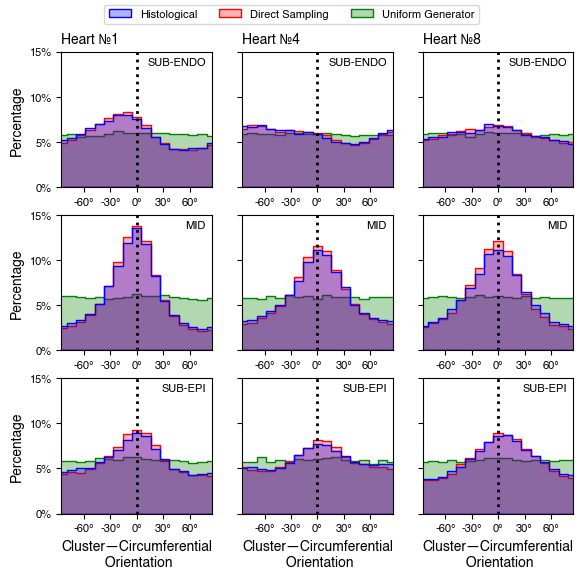

In [42]:
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches


titles = ['A', 'B', 'C']

COLORS = ['blue', 'red', 'green']
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(6.4, 6.),
                        sharex=False, sharey=True)

for i, heart in enumerate(hearts):
    for l, location in enumerate(['SUB-ENDO', 'MID', 'SUB-EPI']):
        ax = axs[l, i]
        ddf = obj_props[(obj_props['heart'] == heart) & (obj_props['location'] == location)]
        plot_orientation(ax, ddf, COLORS, location, y_lim=[0, 15], nbins=18)

    axs[0, i].set_title(f'{heart_labels[i]}', fontsize=10, loc='left')
    axs[-1, i].set_xlabel('Cluster—Circumferential\n Orientation', fontsize=10)

for i in range(3):
    axs[i, 0].set_ylabel('Percentage', fontsize=10)

fig.legend(handles=[mpatches.Patch(facecolor=to_rgba(COLORS[i], alpha=0.3),
                                   edgecolor=COLORS[i],
                                   linewidth=1,
                                   label=l) for i, l in enumerate(['Histological', 
                                                                   'Direct Sampling',
                                                                   'Uniform Generator'])],
           loc='upper center', ncol=3, prop={'size': 8})
plt.subplots_adjust(top=0.92,
                    bottom=0.15,
                    left=0.1,
                    right=0.9,
                    hspace=0.2,
                    wspace=0.2)
plt.show()

In [43]:
path_save = Path('/Users/arstanbek/Projects/fibrosis/FibrosisAnalysis/paperfigures/pdffig')
fig.savefig(path_save.joinpath('Figure8.pdf'),
            format='pdf',
            dpi=1000,
            bbox_inches='tight') 